In [1]:
%matplotlib inline

# Using APDLMath to solve Eigenproblems {#ref_mapdl_math_eigen_solve}

Use APDLMath to solve eigenproblems.

This example uses a verification manual input file, but you can use your
own sparse or dense matrices and solve those.


In [3]:
import time

import matplotlib.pylab as plt
import numpy as np

from ansys.mapdl.core.examples import vmfiles

import ansys.math.core.math as amath

# Start Ansys Math
mm = amath.Math()

First we get the [STIFF]{.title-ref} and [MASS]{.title-ref} matrices
from the full file after running the input file from Verification Manual
153


In [4]:
out = mm._mapdl.input(vmfiles["vm153"])

k = mm.stiff(fname="PRSMEMB.full")
m = mm.mass(fname="PRSMEMB.full")

Display size of the M and K matrices


In [5]:
print(m.shape)
print(k.shape)

(126, 126)
(126, 126)


Allocate an array to store the eigenshapes. where [nev]{.title-ref} is
the number of eigenvalues requested


In [6]:
nev = 10
a = mm.mat(k.nrow, nev)
a

Dense APDLMath Matrix (126, 10)

Perform the the modal analysis.

The algorithm is automatically chosen with respect to the matrices
properties (e.g. scalar, storage, symmetry\...)


In [7]:
print("Calling MAPDL to solve the eigenproblem...")

t1 = time.time()
ev = mm.eigs(nev, k, m, phi=a)
print(f"Elapsed time to solve this problem: {time.time() - t1}")

Calling MAPDL to solve the eigenproblem...
Elapsed time to solve this problem: 0.3018631935119629


This is the vector of eigenfrequencies.


In [8]:
print(ev)

EXWXEZ :
 Size : 10
  3.381e+02   3.381e+02   6.266e+02   6.266e+02   9.283e+02      <       5
  9.283e+02   1.250e+03   1.250e+03   1.424e+03   1.424e+03      <       10


# Verify the accuracy of eigenresults

Check the residual error for the first eigenresult
$R_1=||(K-\lambda_1.M).\phi_1||_2$

First, we compute $\lambda_1 = \omega_1^2 = (2.\pi.f_1)^2$


In [9]:
# Eigenfrequency (Hz)
i = 0
f = ev[0]
omega = 2 * np.pi * f
lam = omega * omega

Then we get the 1st Eigenshape $\phi_1$, and compute $K.\phi_1$ and
$M.\phi_1$


In [10]:
# shape
phi = a[0]

# APDL Command: *MULT,K,,Phi,,KPhi
kphi = k.dot(phi)

# APDL Command: *MULT,M,,Phi,,MPhi
mphi = m.dot(phi)

Next, compute the $||K.\phi_1||_2$ quantity and normalize the residual
value.


In [11]:
# APDL Command: *MULT,K,,Phi,,KPhi
kphi = k.dot(phi)


# APDL Command: *NRM,KPhi,NRM2,KPhiNrm
kphinrm = kphi.norm()

Then we add these two vectors, using the $\lambda_1$ scalar factor and
finally compute the normalized residual value
$\frac{R_1}{||K.\phi_1||_2}$


In [12]:
# APDL Command: *AXPY,-lambda,,MPhi,1,,KPhi
mphi *= lam
kphi -= mphi

# Compute the residual
res = kphi.norm() / kphinrm
print(res)

3.9254968987643776e-11


This residual can be computed for all eigenmodes


In [13]:
def get_res(i):
    """Compute the residual for a given eigenmode"""
    # Eigenfrequency (Hz)
    f = ev[i]

    # omega = 2.pi.Frequency
    omega = 2 * np.pi * f

    # lambda = omega^2
    lam = omega * omega

    # i-th eigenshape
    phi = a[i]

    # K.Phi
    kphi = k.dot(phi)

    # M.Phi
    mphi = m.dot(phi)

    # Normalization scalar value
    kphinrm = kphi.norm()

    # (K-\lambda.M).Phi
    mphi *= lam
    kphi -= mphi

    # return the residual
    return kphi.norm() / kphinrm


mapdl_acc = np.zeros(nev)

for i in range(nev):
    f = ev[i]
    mapdl_acc[i] = get_res(i)
    print(f"[{i}] : Freq = {f}\t - Residual = {mapdl_acc[i]}")

[0] : Freq = 338.0666635506365	 - Residual = 3.9254968987643776e-11
[1] : Freq = 338.06666355063675	 - Residual = 2.8245012411841358e-11
[2] : Freq = 626.6450980927033	 - Residual = 1.6646235069599823e-11
[3] : Freq = 626.6450980927036	 - Residual = 2.3317022893495643e-11
[4] : Freq = 928.2598500574524	 - Residual = 9.19379840256846e-12
[5] : Freq = 928.2598500574542	 - Residual = 5.0619353492161986e-12
[6] : Freq = 1249.842107436349	 - Residual = 5.949488340195741e-12
[7] : Freq = 1249.8421074363528	 - Residual = 1.6612751830345457e-11
[8] : Freq = 1423.9938909416678	 - Residual = 7.628832087008599e-10
[9] : Freq = 1423.993890941671	 - Residual = 7.968362651551089e-11


Plot Accuracy of Eigenresults


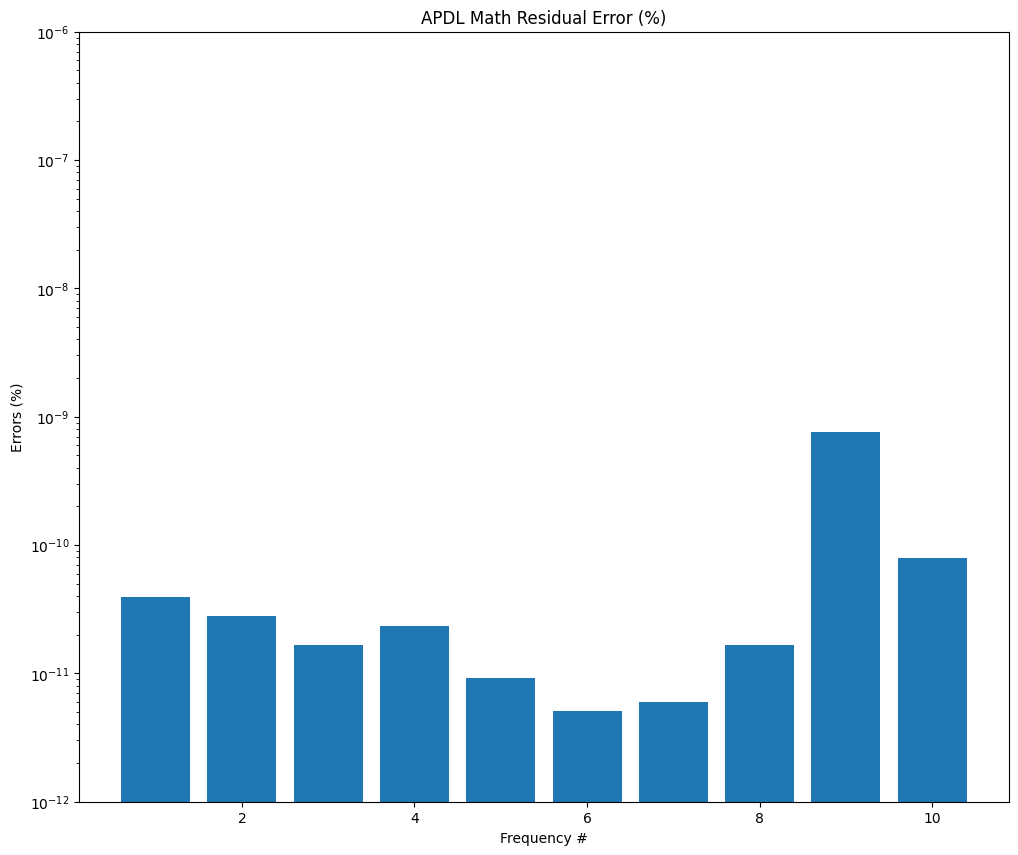

In [14]:
fig = plt.figure(figsize=(12, 10))
ax = plt.axes()
x = np.linspace(1, nev, nev)
plt.title("APDL Math Residual Error (%)")
plt.yscale("log")
plt.ylim([10e-13, 10e-7])
plt.xlabel("Frequency #")
plt.ylabel("Errors (%)")
ax.bar(x, mapdl_acc, label="MAPDL Results")
plt.show()

stop mapdl


In [15]:
mm._mapdl.exit()